In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/differential_learning/gait_merged_dataset.csv')

In [ ]:
def prepare_forecasting_data(full_tensor, input_len=10, forecast_len=10):
    import torch
    if isinstance(full_tensor, np.ndarray):
        full_tensor = torch.tensor(full_tensor, dtype=torch.float32)

    assert full_tensor.shape[1] == (input_len + forecast_len), \
        f"Expected {input_len + forecast_len} trials, got {full_tensor.shape[1]}"

    X_in = full_tensor[:, :input_len, :]
    Y_out = full_tensor[:, input_len:, :]
    return X_in, Y_out

In [ ]:
import torch.nn as nn

class ForecastingTransformer(nn.Module):
    def __init__(self, input_dim=64, model_dim=128, num_heads=4, num_layers=3, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, 10, model_dim))  # input length = 10
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=4*model_dim, dropout=dropout, batch_first=True),
            num_layers=num_layers
        )
        self.decoder = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.ReLU(),
            nn.Linear(model_dim, input_dim)
        )

    def forward(self, x):
        x = self.input_proj(x) + self.pos_embed  # (B, 10, model_dim)
        x = self.transformer(x)  # (B, 10, model_dim)
        out = self.decoder(x)  # (B, 10, input_dim)
        return out

In [ ]:
def train_forecaster(model, X_train, Y_train, epochs=200, lr=1e-4, batch_size=8, device='cuda'):
    import torch
    import torch.nn.functional as F
    from torch.utils.data import DataLoader, TensorDataset

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataset = TensorDataset(X_train, Y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    all_losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = F.mse_loss(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg = epoch_loss / len(loader)
        all_losses.append(avg)
        if epoch % 25 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d}: Loss = {avg:.4f}")
    return all_losses

In [ ]:
def compute_slope(trial_sequence):
    """Computes linear regression slope across trials (1D array)."""
    x = np.arange(len(trial_sequence))
    y = np.array(trial_sequence)
    slope = np.polyfit(x, y, 1)[0]
    return slope

In [ ]:
def evaluate_forecaster(model, X_val, device='cuda'):
    model.eval()
    with torch.no_grad():
        return model(X_val.to(device)).cpu()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_predicted_learning_curve(real_seq, pred_seq, title="Learning Forecast", n_components=1):
    """
    real_seq, pred_seq: (T, D) - trial sequences (e.g., 10x64)
    """
    scaler = StandardScaler()
    combined = np.concatenate([real_seq, pred_seq], axis=0)
    scaled = scaler.fit_transform(combined)

    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(scaled)

    real_proj = reduced[:10].squeeze()
    pred_proj = reduced[10:].squeeze()

    plt.plot(real_proj, label="Real", marker="o")
    plt.plot(pred_proj, label="Predicted", marker="x")
    plt.title(title)
    plt.xlabel("Trial")
    plt.ylabel("PCA(1) of Gait Features")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def slope_score(trial_sequence):
    x = np.arange(len(trial_sequence))
    slope = np.polyfit(x, trial_sequence, 1)[0]
    return slope

In [ ]:
import numpy as np

# Step 1: Extract only numerical features
non_feature_cols = ['subject', 'trial', 'force_column']
feature_cols = [col for col in df.columns if col not in non_feature_cols]

# Step 2: Ensure trials are sorted correctly per subject
df['trial_num'] = df['trial'].str.extract(r'_(\d+)_').astype(int)
df_sorted = df.sort_values(by=['subject', 'trial_num'])

# Step 3: Group by subject and extract trial features
subjects = df_sorted['subject'].unique()
num_subjects = len(subjects)
num_trials = 20
feature_dim = len(feature_cols)

# Step 4: Create (num_subjects, num_trials, feature_dim) array
subject_trial_tensor = np.zeros((num_subjects, num_trials, feature_dim), dtype=np.float32)
valid_subjects = []

for i, subject in enumerate(subjects):
    subject_df = df_sorted[df_sorted['subject'] == subject]
    if len(subject_df) == num_trials:
        subject_trial_tensor[i] = subject_df[feature_cols].values
        valid_subjects.append(subject)

# Report the final shape and number of valid subjects
subject_trial_tensor.shape, len(valid_subjects)

((57, 20, 495), 40)

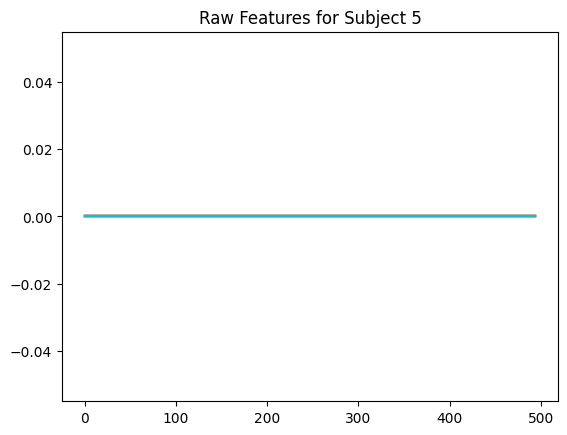

In [ ]:
import matplotlib.pyplot as plt
plt.plot(subject_trial_tensor[5].T)  # Plot all feature curves over trials for Subject 5
plt.title("Raw Features for Subject 5")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# subject_trial_tensor: shape (57, 20, 495)
flat = subject_trial_tensor.reshape(-1, 495)

# PCA → 64D
pca = PCA(n_components=64)
flat_pca = pca.fit_transform(flat)

# Normalize
scaler = StandardScaler()
flat_scaled = scaler.fit_transform(flat_pca)

# Reshape to (57, 20, 64)
gait_tensor_64d = flat_scaled.reshape(subject_trial_tensor.shape[0], 20, 64)

In [ ]:
X_forecast, Y_forecast = prepare_forecasting_data(gait_tensor_64d)

In [ ]:
X_forecast.shape

torch.Size([57, 10, 64])

In [ ]:
import torch

model = ForecastingTransformer(input_dim=64, model_dim=128, num_heads=4, num_layers=3).to('cuda')

In [ ]:
# Make sure X_forecast and Y_forecast are on CPU
X_forecast = X_forecast.float()
Y_forecast = Y_forecast.float()

losses = train_forecaster(
    model=model,
    X_train=X_forecast,
    Y_train=Y_forecast,
    epochs=200,
    lr=1e-4,
    batch_size=8,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Epoch 001: Loss = 1.0739
Epoch 025: Loss = 0.8498
Epoch 050: Loss = 0.6851
Epoch 075: Loss = 0.6496
Epoch 100: Loss = 0.5293
Epoch 125: Loss = 0.4059
Epoch 150: Loss = 0.3962
Epoch 175: Loss = 0.3603
Epoch 200: Loss = 0.2963


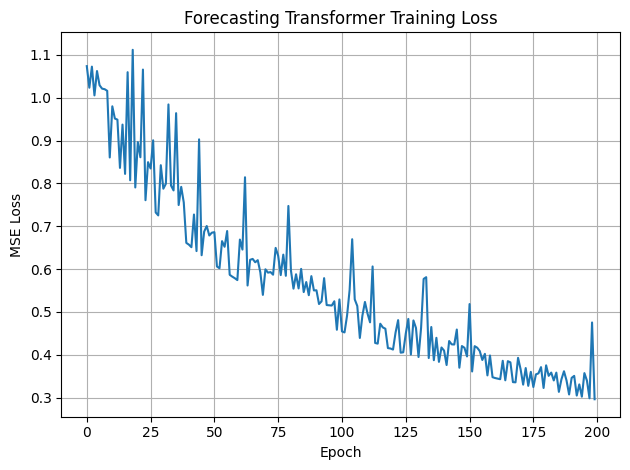

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Forecasting Transformer Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_forecaster(model, X_val, device='cuda'):
    model.eval()
    with torch.no_grad():
        return model(X_val.to(device)).cpu()

In [ ]:
Y_pred = evaluate_forecaster(model, X_forecast)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_predicted_learning_curve(real_seq, pred_seq, title="Learning Forecast", n_components=1):
    scaler = StandardScaler()
    combined = np.concatenate([real_seq, pred_seq], axis=0)
    scaled = scaler.fit_transform(combined)

    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(scaled)

    real_proj = reduced[:10].squeeze()
    pred_proj = reduced[10:].squeeze()

    plt.plot(real_proj, label="Real", marker="o")
    plt.plot(pred_proj, label="Predicted", marker="x")
    plt.title(title)
    plt.xlabel("Trial")
    plt.ylabel("PCA(1) of Gait Features")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

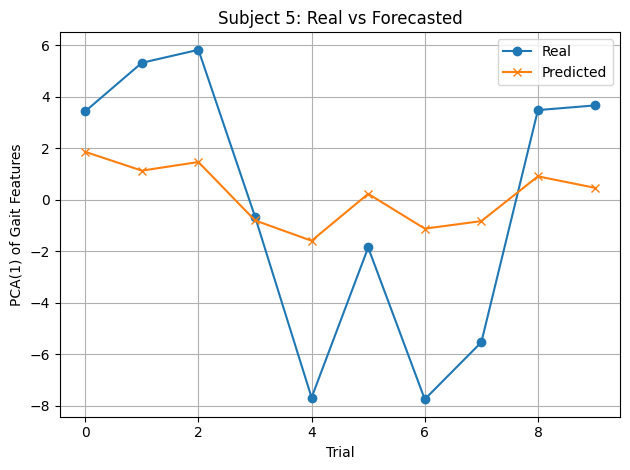

In [ ]:
real_seq = Y_forecast[6].numpy()
pred_seq = Y_pred[6].numpy()

plot_predicted_learning_curve(real_seq, pred_seq, title="Subject 5: Real vs Forecasted")

In [ ]:
real_mean = real_seq.mean(axis=1)
pred_mean = pred_seq.mean(axis=1)

print("Real Slope:", slope_score(real_mean))
print("Predicted Slope:", slope_score(pred_mean))

Real Slope: 0.01597972433223869
Predicted Slope: 0.0004012416935328287


# Analyze All Subjects

In [ ]:
import numpy as np

def compute_slope(sequence):
    x = np.arange(len(sequence))
    return np.polyfit(x, sequence, 1)[0]

def analyze_all_subjects(Y_true, Y_pred):
    """
    Computes real slope, predicted slope, and absolute gap for each subject.

    Args:
        Y_true: tensor (N, 10, D) - actual future trials
        Y_pred: tensor (N, 10, D) - model forecast

    Returns:
        List of dicts with keys: subject_id, real_slope, pred_slope, gap
    """
    results = []
    for i in range(Y_true.shape[0]):
        real_seq = Y_true[i].numpy()
        pred_seq = Y_pred[i].numpy()

        real_mean = real_seq.mean(axis=1)
        pred_mean = pred_seq.mean(axis=1)

        real_slope = compute_slope(real_mean)
        pred_slope = compute_slope(pred_mean)
        gap = abs(real_slope - pred_slope)

        results.append({
            "subject_id": i+1,
            "real_slope": real_slope,
            "pred_slope": pred_slope,
            "slope_gap": gap
        })

    return results

In [ ]:
import matplotlib.pyplot as plt

def plot_slope_scatter(results):
    real = [r['real_slope'] for r in results]
    pred = [r['pred_slope'] for r in results]
    gap  = [r['slope_gap']  for r in results]

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(real, pred, c=gap, cmap='coolwarm', edgecolors='k')
    plt.colorbar(scatter, label="Slope Gap (|real - predicted|)")
    plt.xlabel("Real Slope")
    plt.ylabel("Predicted Slope")
    plt.title("Subject Forecastability Landscape")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


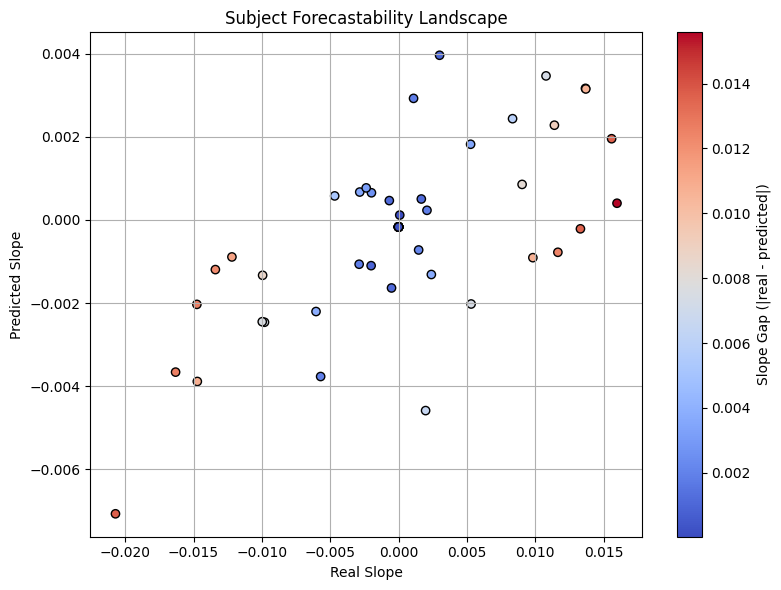

In [ ]:
results = analyze_all_subjects(Y_forecast, Y_pred)
plot_slope_scatter(results)

# Rank Subjects by Forecastability

In [ ]:
import pandas as pd

def rank_subjects_by_gap(results, top_n=5):
    df = pd.DataFrame(results)
    top_learners = df.nsmallest(top_n, 'slope_gap')
    worst_forecasts = df.nlargest(top_n, 'slope_gap')
    return top_learners, worst_forecasts

In [ ]:
top, bottom = rank_subjects_by_gap(results)
print("🔥 Top Learners:\n", top)
print("\n💥 Worst Forecasted Subjects:\n", bottom)

🔥 Top Learners:
     subject_id    real_slope  pred_slope  slope_gap
42          43  8.689797e-05    0.000116   0.000029
2            3 -1.897640e-08   -0.000169   0.000169
4            5 -1.051566e-18   -0.000169   0.000169
5            6 -1.051566e-18   -0.000169   0.000169
7            8 -1.051566e-18   -0.000169   0.000169

💥 Worst Forecasted Subjects:
     subject_id  real_slope  pred_slope  slope_gap
6            7    0.015980    0.000401   0.015578
17          18   -0.020708   -0.007066   0.013642
36          37    0.015586    0.001952   0.013634
33          34    0.013304   -0.000214   0.013519
48          49   -0.014754   -0.002031   0.012724


# Plot Learning Curves for Ranked Subjects

In [ ]:
def plot_subject_curve(real_seq, pred_seq, subject_id):
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    scaler = StandardScaler()
    combined = np.concatenate([real_seq, pred_seq], axis=0)
    scaled = scaler.fit_transform(combined)
    reduced = PCA(n_components=1).fit_transform(scaled)

    real_proj = reduced[:10].squeeze()
    pred_proj = reduced[10:].squeeze()

    plt.plot(real_proj, label="Real", marker='o')
    plt.plot(pred_proj, label="Predicted", marker='x')
    plt.title(f"Subject {subject_id}: Real vs Forecasted")
    plt.xlabel("Trial")
    plt.ylabel("PCA(1) of Gait Features")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

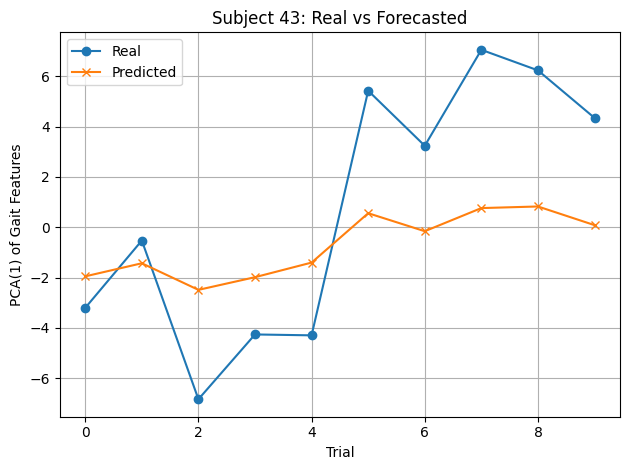

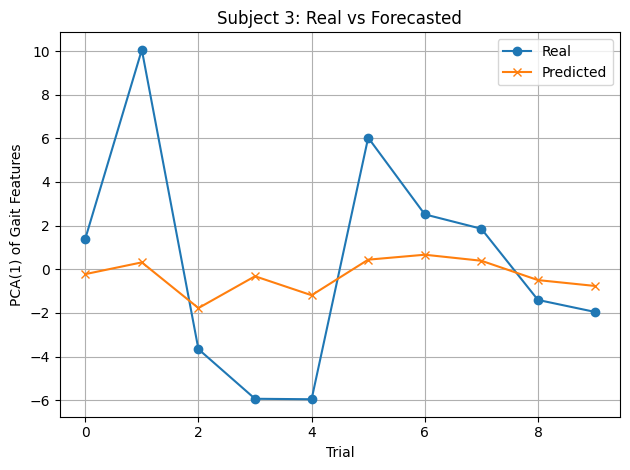

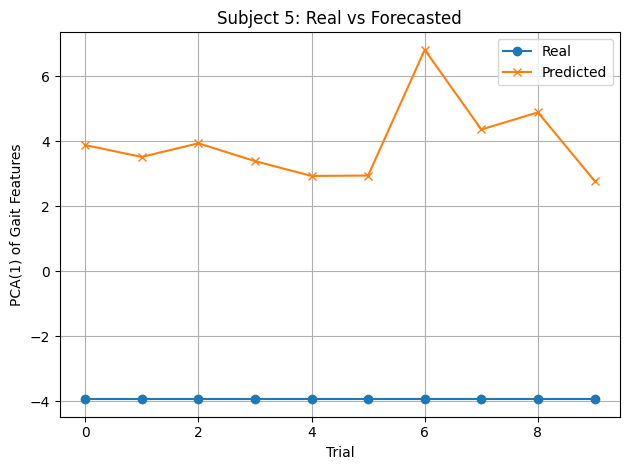

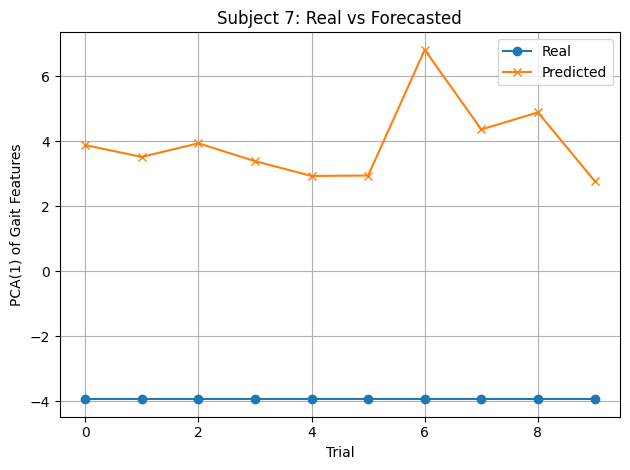

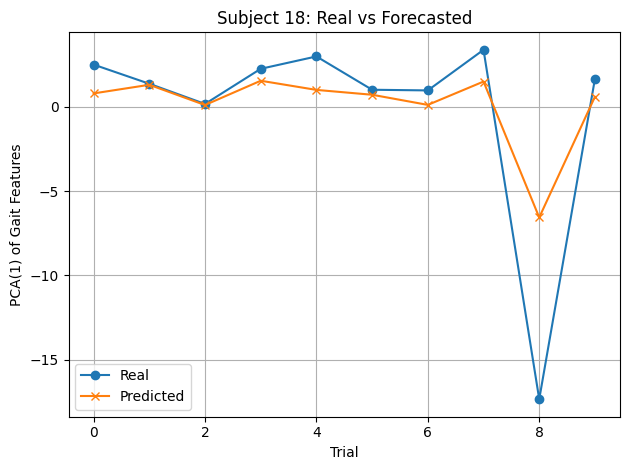

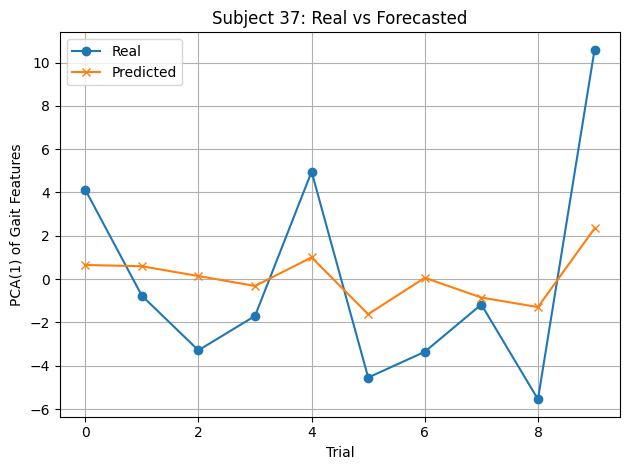

In [ ]:
# Plot top 3
for sid in top['subject_id'].values[:3]:
    plot_subject_curve(Y_forecast[sid].numpy(), Y_pred[sid].numpy(), sid)

# Plot bottom 3
for sid in bottom['subject_id'].values[:3]:
    plot_subject_curve(Y_forecast[sid].numpy(), Y_pred[sid].numpy(), sid)


In [ ]:
forecast_df = pd.DataFrame(results)

print(forecast_df.head())

   subject_id    real_slope  pred_slope  slope_gap
0           1  5.269888e-03    0.001819   0.003451
1           2  4.899321e-08   -0.000169   0.000169
2           3 -1.897640e-08   -0.000169   0.000169
3           4 -1.340096e-02   -0.001194   0.012207
4           5 -1.051566e-18   -0.000169   0.000169


In [ ]:
forecast_df.to_csv("/content/drive/MyDrive/differential_learning/subject_forecast_scores.csv", index=False)